In [ ]:
from google.colab import files
uploaded = files.upload()

Saving reverb_dataset.py to reverb_dataset.py
Saving utils.py to utils.py


In [ ]:
uploaded = files.upload()

Saving sequential_models.py to sequential_models.py


In [ ]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display as display
import soundfile as sf
import os
import sys
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
from utils import generate_spec, reconstruct_wave, graph_spec, normalize, \
                  split_specgram, split_realdata, prepare_data 
from reverb_dataset import ReverbDataset
from sequential_models import LSTMDNN

     |████████████████████████████████| 25.9MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!pip install SciencePlots

  Created wheel for SciencePlots: filename=SciencePlots-1.0.7-cp37-none-any.whl size=5460 sha256=fd455d755e48c27be374c70f3e0c3627c3ff187d80517ae716e700e4efd8f09a
  Stored in directory: /root/.cache/pip/wheels/65/01/f1/d910b2dd79844adab51de69f6f753cd10af4d0563e9ef19a24
Successfully built SciencePlots


In [ ]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apache2 | lighttpd | httpd poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arph

# Data

Need at least 16 GB RAM for the 4 tensors. You can generate the tensors with data_generation notebooks (Generate_spectrograms.ipynb and Normalize_spectrograms.ipynb)

Load a smaller file number (for train) if you have less RAM

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n1.pth')
X_train2 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n2.pth')
X_train3 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n3.pth')
X_train4 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n4.pth')
y_train1 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n1.pth')
y_train2 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n2.pth')
y_train3 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n3.pth')
y_train4 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n4.pth')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([20000, 1, 128, 340])
torch.Size([20000, 1, 128, 340])


# Training

In [ ]:
def trainer_sec(model, train_loader, val_loader, checkpoints, nEpochs = 100, lr = 1e-3):
  """
  Train model

  model: LSTM based neural network
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """

  criterion = nn.MSELoss()
  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  optimizer = torch.optim.Adam(model.parameters(), lr, (beta1, beta2))

  train_loss = []
  val_loss = []
  
  model.train()
  for epoch in range(nEpochs):
    temp_train_loss = 0.0
    corrects_train = 0
    for i, (rev_data, clean_data) in enumerate(train_loader):
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()
      rev_data, clean_data = prepare_data(rev_data, clean_data)

      optimizer.zero_grad()
      output = model(rev_data)
      loss_train = criterion(output, clean_data)
      loss_train.backward()
      optimizer.step()

      temp_train_loss += loss_train.item()

    temp_val_loss = 0.0    
    #Validacion
    model.eval()
    with torch.no_grad():
      for i, (rev_data, clean_data) in enumerate(val_loader):
        rev_data = rev_data.cuda()
        clean_data = clean_data.cuda()

        rev_data, clean_data = prepare_data(rev_data, clean_data)
        output = model(rev_data)
        loss_val = criterion(output, clean_data)
        temp_val_loss += loss_val.item()

    train_loss.append(temp_train_loss)
    val_loss.append(temp_val_loss)

    print('Epoch : {} || Train Loss: {:.3f} || Val Loss: {:.3f}'\
         .format(epoch+1, loss_train.item(), loss_val.item()))
    model.train()
    
    if ((epoch+1)%5 == 0):
      torch.save(model.state_dict(), checkpoints[0])
      torch.save(train_loss, checkpoints[1])
      torch.save(val_loss, checkpoints[2])
      print("saved models")

    if (epoch % decay_rate == 1):
       optimizer.param_groups[0]['lr'] *= lr_decay

  return train_loss, val_loss

In [ ]:
total_dataset = ReverbDataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

17000
3000


In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 1, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 1, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
net = LSTMDNN()
net = net.cuda()

checkpoints = ['/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', '/content/drive/My Drive/data_audio/losses/train_loss_lstm.pth', 
               '/content/drive/My Drive/data_audio/losses/val_loss_lstm.pth']

#329 frames = 1 specgram
train_loss, val_loss = trainer_sec(net, train_loader, val_loader, checkpoints, nEpochs = 50, lr=2e-4)

Epoch : 1 || Train Loss: 0.089 || Val Loss: 0.089
Epoch : 2 || Train Loss: 0.078 || Val Loss: 0.083
Epoch : 3 || Train Loss: 0.081 || Val Loss: 0.057
Epoch : 4 || Train Loss: 0.073 || Val Loss: 0.073
Epoch : 5 || Train Loss: 0.052 || Val Loss: 0.086
saved models
Epoch : 6 || Train Loss: 0.065 || Val Loss: 0.060
Epoch : 7 || Train Loss: 0.067 || Val Loss: 0.100
Epoch : 8 || Train Loss: 0.047 || Val Loss: 0.062
Epoch : 9 || Train Loss: 0.067 || Val Loss: 0.050
Epoch : 10 || Train Loss: 0.065 || Val Loss: 0.049
saved models
Epoch : 11 || Train Loss: 0.038 || Val Loss: 0.044
Epoch : 12 || Train Loss: 0.029 || Val Loss: 0.065
Epoch : 13 || Train Loss: 0.060 || Val Loss: 0.065
Epoch : 14 || Train Loss: 0.052 || Val Loss: 0.049
Epoch : 15 || Train Loss: 0.039 || Val Loss: 0.051
saved models
Epoch : 16 || Train Loss: 0.068 || Val Loss: 0.070
Epoch : 17 || Train Loss: 0.046 || Val Loss: 0.050
Epoch : 18 || Train Loss: 0.044 || Val Loss: 0.062
Epoch : 19 || Train Loss: 0.088 || Val Loss: 0.051
E

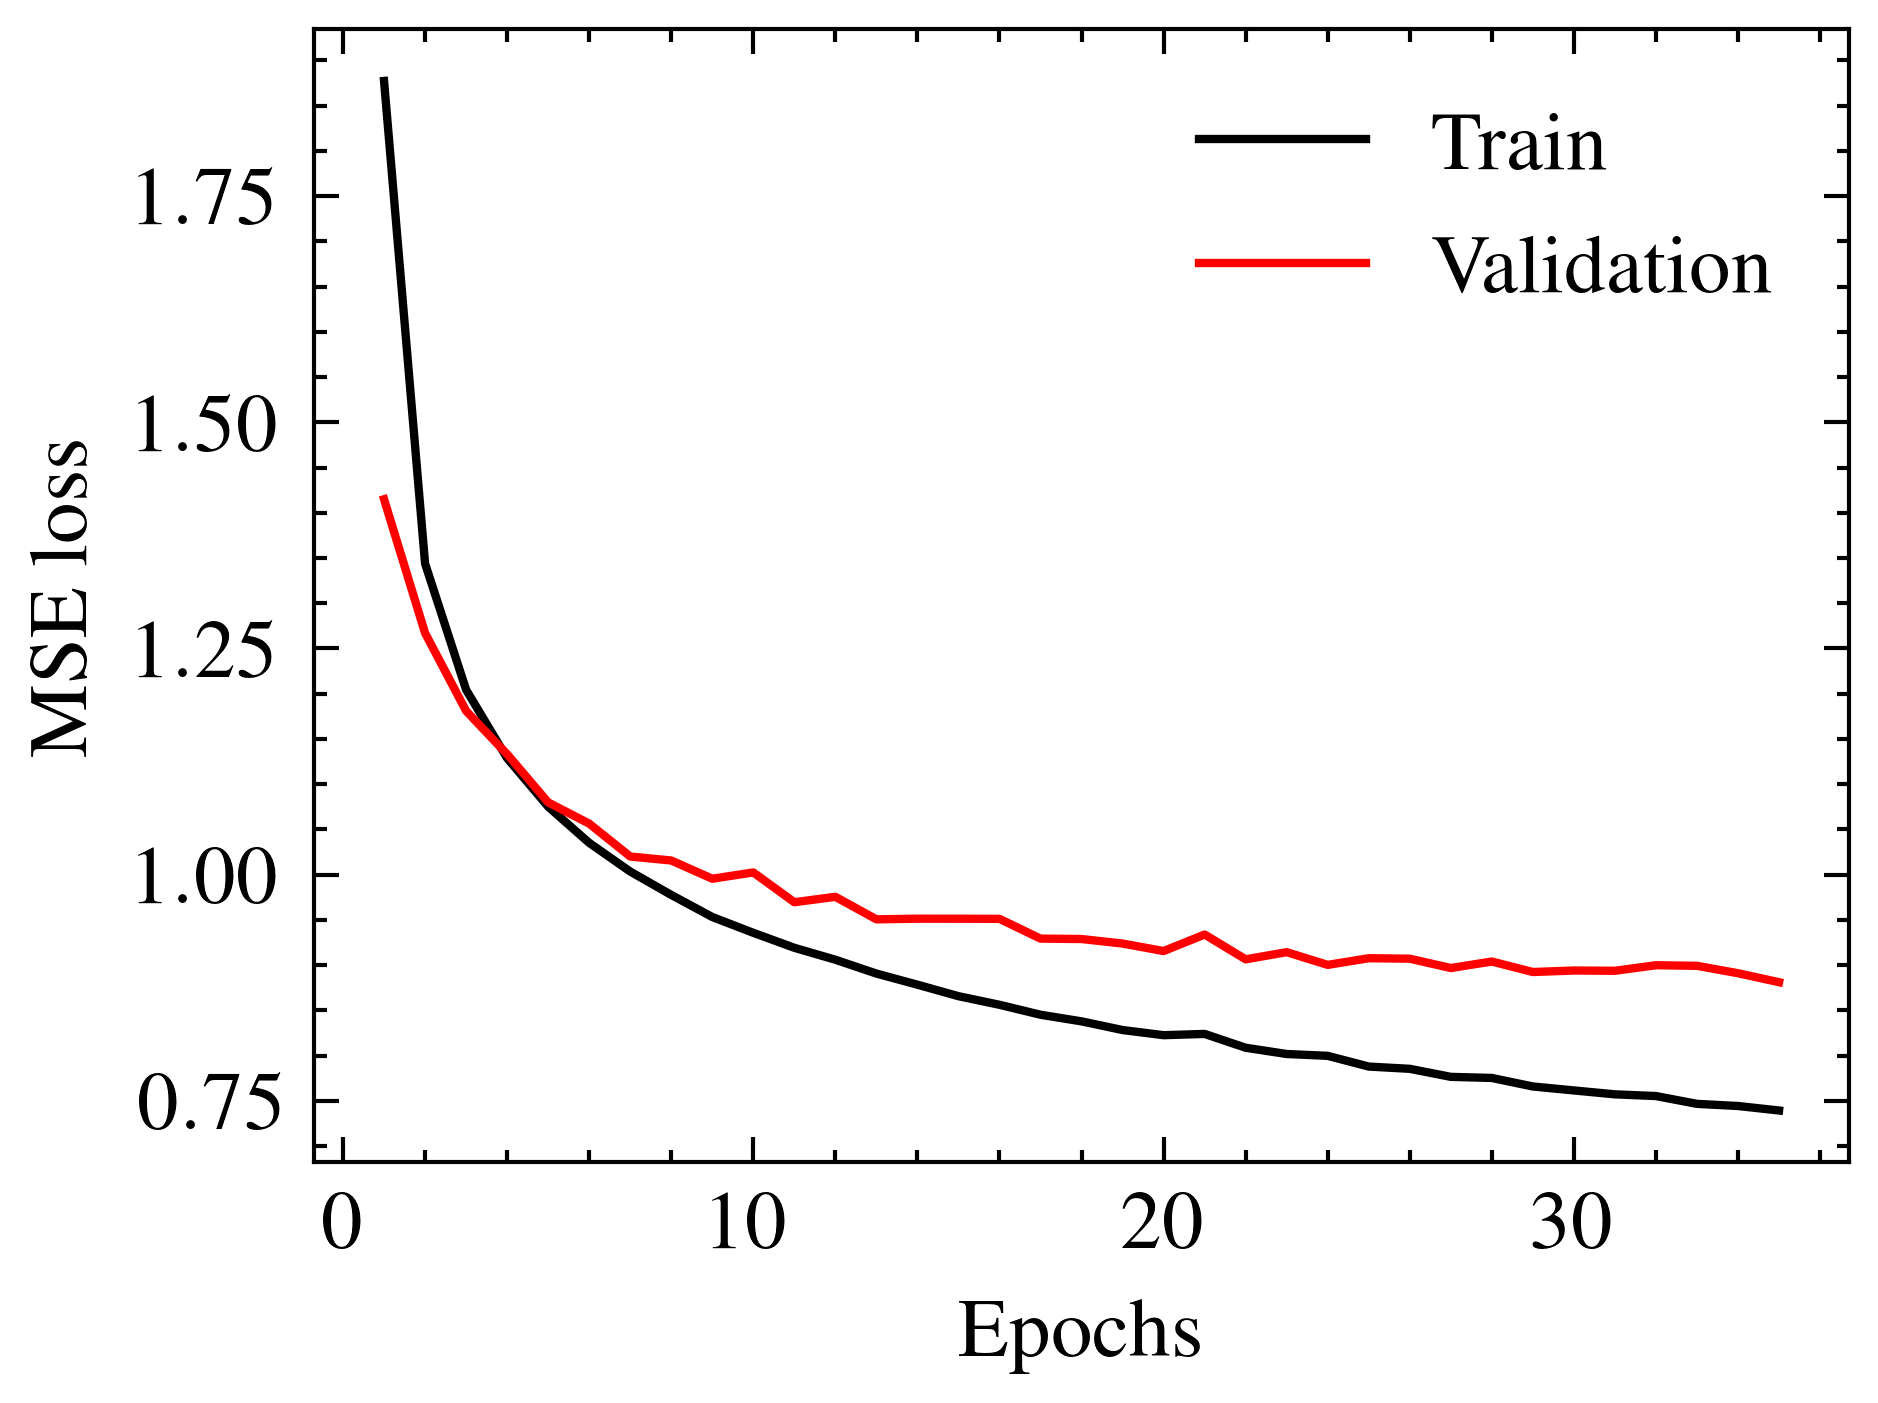

In [ ]:
plt.style.reload_library()
plt.style.use(['science', 'ieee'])
train_loss = torch.load('/content/drive/My Drive/data_audio/train_loss_lstm3')
val_loss = torch.load('/content/drive/My Drive/data_audio/val_loss_lstm3')

train_loss = (16/17000)*np.array(train_loss)
val_loss = (16/3000)*np.array(val_loss)

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(np.arange(1, 36, 1), train_loss, '-', label = 'Train')
plt.plot(np.arange(1, 36, 1), val_loss, '-', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()

# Qualitative evaluation

In [ ]:
def evaluate_qualitative(net, audio_path, num_example, speech_rate=16000):
  """
  net: LSTM based model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  matplotlib.rc('xtick', labelsize=15)  
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})
  plt.rcParams["font.family"] = "serif"

  waves_rev = torch.load(audio_path[0])
  waves_target = torch.load(audio_path[1])

  rev_spec = generate_spec(waves_rev[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)

  net.eval()

  ex_rev_norm, ex_data_norm = normalize(rev_spec)
  target_norm, target_data_norm = normalize(clean_spec)

  spec_test0, targets0 = split_specgram(torch.tensor(ex_rev_norm[None,:,:]), torch.tensor(target_norm[None,:,:]))
  spec_test_response = net(spec_test0).cpu().detach().numpy().T

  spec_test_response = spec_test_response*(ex_data_norm[1]+1e-6) + ex_data_norm[0]

  graph_spec(clean_spec)
  graph_spec(rev_spec)
  graph_spec(spec_test_response)

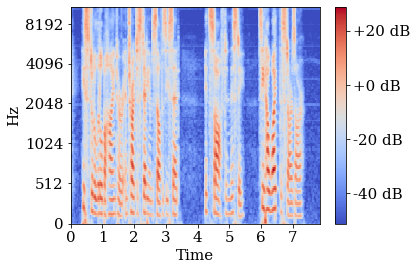

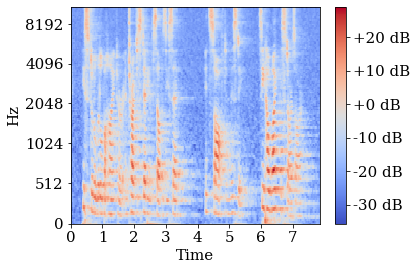

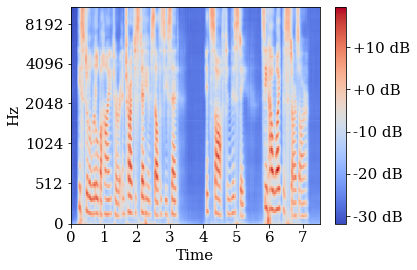

In [ ]:
net = LSTMDNN()
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage))
paths = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, paths, 100)

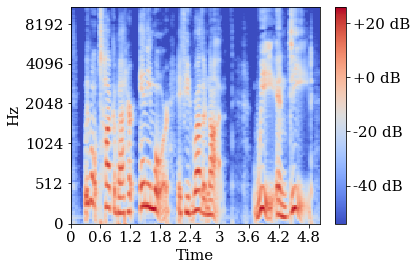

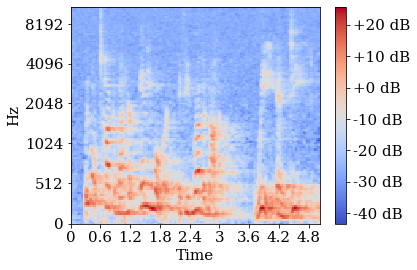

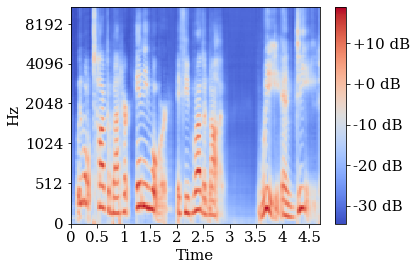

In [ ]:
net = LSTMDNN()
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage))
paths = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, paths, 300)

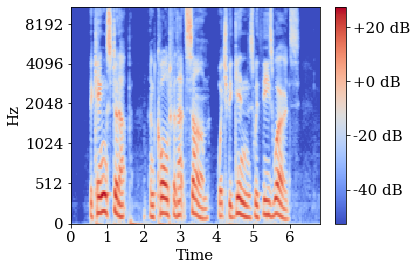

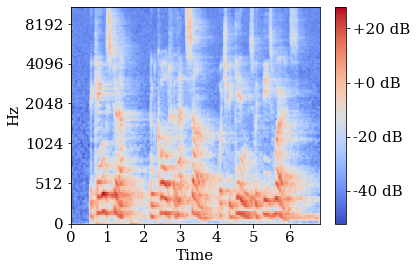

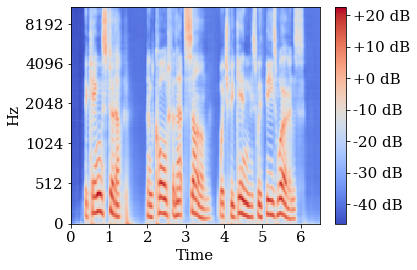

In [ ]:
net = LSTMDNN()
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage))
paths = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, paths, 400)


# Quantitative evaluation

Pysepm metrics

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     - 2.1MB 2.2MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     | 71kB 53.7MB/s
     | 276kB 25.0MB/s
     / 65.3MB 45kB/s
     |████████████████████████████████| 163kB 4.3MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=2a1b951eb530f878490609cf988ae945c0695e4e2ae3cc1578de73573d82dcaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-aw80v9gj/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=b768351d8aba1ec4bea9c9a337794745bafc7432fcb7209c80dc99532313a246
  Stored in directory: /root/.cache/pip/wheels/6b/6c/b2/d49af4b7ee4ce275cf2511484b043e09b9cb7ae90c1accb17a
  Created wheel for SRMRpy: filename=SRMRpy-1.0-cp37-none-any.whl size=9397 sha256=b6666a22604beec81daf32db8d3de76f040d0efc2d9bfbeade5a78a5fb392485
  Stored in directory: /t

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import llr, cepstrum_distance, fwSNRseg, srmr 
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=84217 sha256=40087a7d1846bfa6330feae5d77bbe0aac0b06fb65005f780deedafc0defe475
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate(net, path_results, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: LSTM based model to evaluate
  path_results: base directory to save results
  path_waves: list of 2 paths representing target and reverb waveforms respectively 
  init_example: first example in waveforms to be considered
  end_example: last example in waveforms to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """
   
  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path_results + 'reverb_pesq_lstm.pth')
    reverb_stoi_list = torch.load(path_results + 'reverb_stoi_lstm.pth')
    reverb_llr_list = torch.load(path_results + 'reverb_llr_lstm.pth')
    reverb_cd_list = torch.load(path_results + 'reverb_cd_lstm.pth')
    reverb_fwSNRseg_list = torch.load(path_results + 'reverb_fwSNRseg_lstm.pth')
    reverb_srmr_list = torch.load(path_results + 'reverb_srmr_lstm.pth')

    dereverb_pesq_list = torch.load(path_results + 'dereverb_pesq_lstm.pth')
    dereverb_stoi_list = torch.load(path_results + 'dereverb_stoi_lstm.pth')
    dereverb_llr_list = torch.load(path_results + 'dereverb_llr_lstm.pth')
    dereverb_cd_list = torch.load(path_results + 'dereverb_cd_lstm.pth')
    dereverb_fwSNRseg_list = torch.load(path_results + 'dereverb_fwSNRseg_lstm.pth')
    dereverb_srmr_list = torch.load(path_results + 'dereverb_srmr_lstm.pth')

  clean_waves = torch.load(path_waves[0])
  rev_waves = torch.load(path_waves[1])
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(clean_waves[i], speech_rate)
    rev_spec = generate_spec(rev_waves[i], speech_rate)

    rev_copy = torch.zeros((1, real_spec.shape[0], real_spec.shape[1]))
    target_copy = torch.zeros((1, real_spec.shape[0], real_spec.shape[1]))
    target_copy[0, :, :] = torch.clone(torch.tensor(real_spec))
    rev_copy[0, :, :] = torch.clone(torch.tensor(rev_spec))

    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())
      norm_target, norm_stats_target = normalize(target_copy[0, :, :].numpy())
      
      rev_copy_norm = torch.zeros((rev_copy.shape))
      target_copy_norm = torch.zeros((target_copy.shape))
      
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
      target_copy_norm[0, :, :] = torch.tensor(norm_target)
       
      spec_test, targets = split_specgram(rev_copy_norm, target_copy_norm)  
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)
      targets = targets*(norm_stats_target[1] + 1e-6) + norm_stats_target[0] # denormalize (it doesnt use the target)
      targets = targets.T

    else:
      spec_test, targets = split_specgram(rev_copy[0, :, :].numpy(), target_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    original = reconstruct_wave(targets.numpy())
    reverb = rev_waves[i]
    recon = reconstruct_wave(spec_test_response)
    
    #metrics
    pesq_metric_rev = pesq(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    stoi_metric_rev = stoi(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    llr_metric_rev = llr(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    cd_metric_rev = cepstrum_distance(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    fwSNRseg_metric_rev = fwSNRseg(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    srmr_metric_rev = srmr(reverb, speech_rate)

    pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
    stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
    llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
    cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
    fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
    srmr_metric_recon = srmr(recon, speech_rate)

    reverb_pesq_list.append(pesq_metric_rev)
    reverb_stoi_list.append(stoi_metric_rev)
    reverb_llr_list.append(llr_metric_rev)
    reverb_cd_list.append(cd_metric_rev)
    reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
    reverb_srmr_list.append(srmr_metric_rev)

    dereverb_pesq_list.append(pesq_metric_recon)
    dereverb_stoi_list.append(stoi_metric_recon)
    dereverb_llr_list.append(llr_metric_recon)
    dereverb_cd_list.append(cd_metric_recon)
    dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
    print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
    print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
    print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
    print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path_results + 'reverb_pesq_lstm.pth')
      torch.save(reverb_stoi_list, path_results + 'reverb_stoi_lstm.pth')
      torch.save(reverb_llr_list, path_results + 'reverb_llr_lstm.pth')
      torch.save(reverb_cd_list, path_results + 'reverb_cd_lstm.pth')
      torch.save(reverb_fwSNRseg_list, path_results + 'reverb_fwSNRseg_lstm.pth')
      torch.save(reverb_srmr_list, path_results + 'reverb_srmr_lstm.pth')

      torch.save(dereverb_pesq_list, path_results + 'dereverb_pesq_lstm.pth')
      torch.save(dereverb_stoi_list, path_results + 'dereverb_stoi_lstm.pth')
      torch.save(dereverb_llr_list, path_results + 'dereverb_llr_lstm.pth')
      torch.save(dereverb_cd_list, path_results + 'dereverb_cd_lstm.pth')
      torch.save(dereverb_fwSNRseg_list, path_results + 'dereverb_fwSNRseg_lstm.pth')
      torch.save(dereverb_srmr_list, path_results + 'dereverb_srmr_lstm.pth')
      
      print('Saved')

## Room Simulated 1

In [ ]:
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room1/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev.pth']

evaluate(model_lstm, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.241 || PESQ dereverberated signal: 2.485
STOI reverberated signal: 0.840 || STOI dereverberated signal: 0.811
LLR reverberated signal: 0.341 || LLR dereverberated signal: 0.387
CD reverberated signal: 3.498 || CD dereverberated signal: 3.328
fwSNRseg reverberated signal: 9.593 || fwSNRseg dereverberated signal: 9.908
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 3.726


Processing specgram n°:2
PESQ reverberated signal: 2.171 || PESQ dereverberated signal: 2.434
STOI reverberated signal: 0.808 || STOI dereverberated signal: 0.799
LLR reverberated signal: 0.377 || LLR dereverberated signal: 0.383
CD reverberated signal: 3.738 || CD dereverberated signal: 3.311
fwSNRseg reverberated signal: 8.344 || fwSNRseg dereverberated signal: 9.604
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 3.874


Processing specgram n°:3
PESQ reverberated signal: 2.146 || PESQ dereverberated signal: 2.362


In [ ]:
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room1/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev.pth']

evaluate(model_lstm, path, path_waves, 30, 500, normalize_data = True, initial = False)

Current device: cpu
Processing specgram n°:31
PESQ reverberated signal: 2.067 || PESQ dereverberated signal: 2.480
STOI reverberated signal: 0.822 || STOI dereverberated signal: 0.798
LLR reverberated signal: 0.381 || LLR dereverberated signal: 0.376
CD reverberated signal: 3.774 || CD dereverberated signal: 3.328
fwSNRseg reverberated signal: 8.958 || fwSNRseg dereverberated signal: 9.893
SRMR reverberated signal: 2.711 || SRMR dereverberated signal: 3.374


Processing specgram n°:32
PESQ reverberated signal: 2.281 || PESQ dereverberated signal: 2.516
STOI reverberated signal: 0.855 || STOI dereverberated signal: 0.839
LLR reverberated signal: 0.350 || LLR dereverberated signal: 0.351
CD reverberated signal: 3.636 || CD dereverberated signal: 3.199
fwSNRseg reverberated signal: 9.623 || fwSNRseg dereverberated signal: 10.289
SRMR reverberated signal: 3.135 || SRMR dereverberated signal: 3.745


Processing specgram n°:33
PESQ reverberated signal: 2.199 || PESQ dereverberated signal: 2.

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.11
STOI: 0.84
LLR: 0.81
CD: 5.39
fwSNRseg: 7.69
SRMR: 3.17

Dereverberated signal:
PESQ: 2.09
STOI: 0.79
LLR: 0.82
CD: 4.84
fwSNRseg: 7.30
SRMR: 3.24


## Room Simulated 2

In [ ]:
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room2/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_2.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth']

evaluate(model_lstm, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.296 || PESQ dereverberated signal: 2.127
STOI reverberated signal: 0.614 || STOI dereverberated signal: 0.632
LLR reverberated signal: 1.095 || LLR dereverberated signal: 1.006
CD reverberated signal: 6.273 || CD dereverberated signal: 5.505
fwSNRseg reverberated signal: 7.129 || fwSNRseg dereverberated signal: 6.632
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 2.052


Processing specgram n°:2
PESQ reverberated signal: 2.240 || PESQ dereverberated signal: 2.116
STOI reverberated signal: 0.670 || STOI dereverberated signal: 0.665
LLR reverberated signal: 1.256 || LLR dereverberated signal: 0.955
CD reverberated signal: 6.942 || CD dereverberated signal: 5.192
fwSNRseg reverberated signal: 6.317 || fwSNRseg dereverberated signal: 6.170
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 1.953


Processing specgram n°:3
PESQ reverberated signal: 2.191 || PESQ dereverberated signal: 2.003


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.15
STOI: 0.67
LLR: 0.97
CD: 5.71
fwSNRseg: 6.58
SRMR: 4.49

Dereverberated signal:
PESQ: 1.90
STOI: 0.63
LLR: 1.05
CD: 5.64
fwSNRseg: 6.12
SRMR: 2.60


## Room Simulated 3

In [ ]:
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room3/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_3.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_3.pth']

evaluate(model_lstm, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.574 || PESQ dereverberated signal: 2.334
STOI reverberated signal: 0.762 || STOI dereverberated signal: 0.756
LLR reverberated signal: 1.021 || LLR dereverberated signal: 0.932
CD reverberated signal: 6.051 || CD dereverberated signal: 5.481
fwSNRseg reverberated signal: 9.153 || fwSNRseg dereverberated signal: 7.973
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 2.718


Processing specgram n°:2
PESQ reverberated signal: 2.540 || PESQ dereverberated signal: 2.329
STOI reverberated signal: 0.799 || STOI dereverberated signal: 0.792
LLR reverberated signal: 1.174 || LLR dereverberated signal: 0.886
CD reverberated signal: 6.630 || CD dereverberated signal: 5.058
fwSNRseg reverberated signal: 7.911 || fwSNRseg dereverberated signal: 7.044
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 2.509


Processing specgram n°:3
PESQ reverberated signal: 2.588 || PESQ dereverberated signal: 2.265


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.57
STOI: 0.83
LLR: 0.85
CD: 5.25
fwSNRseg: 8.68
SRMR: 5.21

Dereverberated signal:
PESQ: 2.14
STOI: 0.77
LLR: 0.99
CD: 5.49
fwSNRseg: 7.21
SRMR: 3.05


## Room Simulated 4

In [ ]:
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room4/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_4.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_4.pth']

evaluate(model_lstm, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.372 || PESQ dereverberated signal: 2.355
STOI reverberated signal: 0.832 || STOI dereverberated signal: 0.827
LLR reverberated signal: 0.413 || LLR dereverberated signal: 0.454
CD reverberated signal: 3.930 || CD dereverberated signal: 3.659
fwSNRseg reverberated signal: 8.718 || fwSNRseg dereverberated signal: 8.503
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 4.281


Processing specgram n°:2
PESQ reverberated signal: 2.439 || PESQ dereverberated signal: 2.457
STOI reverberated signal: 0.852 || STOI dereverberated signal: 0.829
LLR reverberated signal: 0.530 || LLR dereverberated signal: 0.398
CD reverberated signal: 4.465 || CD dereverberated signal: 3.426
fwSNRseg reverberated signal: 9.210 || fwSNRseg dereverberated signal: 8.756
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 3.773


Processing specgram n°:3
PESQ reverberated signal: 2.346 || PESQ dereverberated signal: 2.193


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.17
STOI: 0.85
LLR: 0.59
CD: 4.69
fwSNRseg: 8.12
SRMR: 3.15

Dereverberated signal:
PESQ: 2.31
STOI: 0.82
LLR: 0.52
CD: 3.91
fwSNRseg: 8.42
SRMR: 4.06


## Simulated room 5

In [ ]:
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room5/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_5.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_5.pth']

evaluate(model_lstm, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 1.951 || PESQ dereverberated signal: 1.703
STOI reverberated signal: 0.760 || STOI dereverberated signal: 0.711
LLR reverberated signal: 1.263 || LLR dereverberated signal: 1.261
CD reverberated signal: 6.593 || CD dereverberated signal: 5.992
fwSNRseg reverberated signal: 5.571 || fwSNRseg dereverberated signal: 4.823
SRMR reverberated signal: 3.246 || SRMR dereverberated signal: 2.175


Processing specgram n°:2
PESQ reverberated signal: 1.884 || PESQ dereverberated signal: 1.826
STOI reverberated signal: 0.771 || STOI dereverberated signal: 0.729
LLR reverberated signal: 1.256 || LLR dereverberated signal: 1.328
CD reverberated signal: 6.778 || CD dereverberated signal: 6.351
fwSNRseg reverberated signal: 6.492 || fwSNRseg dereverberated signal: 4.968
SRMR reverberated signal: 3.948 || SRMR dereverberated signal: 2.367


Processing specgram n°:3
PESQ reverberated signal: 2.040 || PESQ dereverberated signal: 1.937


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.97
STOI: 0.80
LLR: 1.36
CD: 7.30
fwSNRseg: 6.38
SRMR: 3.08

Dereverberated signal:
PESQ: 1.68
STOI: 0.72
LLR: 1.36
CD: 6.73
fwSNRseg: 5.20
SRMR: 1.93


In [ ]:
def evaluate_realdata(net, path_results, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: LSTM based model to evaluate
  path_results: base directory to save results
  path_waves: path representing reverb waveforms 
  init_example: first example in dataset to be considered
  end_example: last example in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path_results + 'reverb_srmr_lstm.pth')
    dereverb_srmr_list = torch.load(path_results + 'dereverb_srmr_lstm.pth')

  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_copy = torch.zeros((1, real_spec.shape[0], real_spec.shape[1]))
    rev_copy[0, :, :] = torch.clone(torch.tensor(real_spec))
    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())      
      rev_copy_norm = torch.zeros((rev_copy.shape))    
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
  
      spec_test = split_realdata(rev_copy_norm) 
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)

    else:
      spec_test = split_realdata(rev_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    #SRMR evaluation
    recon = reconstruct_wave(spec_test_response)
    
    srmr_metric_rev = srmr(waves[i], speech_rate)
    srmr_metric_recon = srmr(recon, speech_rate)

    reverb_srmr_list.append(srmr_metric_rev)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):

      torch.save(reverb_srmr_list, path_results + 'reverb_srmr_lstm.pth')
      torch.save(dereverb_srmr_list, path_results + 'dereverb_srmr_lstm.pth')
      
      print('Saved')

## Far real data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves2.pth'
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)

evaluate_realdata(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 5.532


Processing specgram n°:2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 4.790


Processing specgram n°:3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 5.781


Processing specgram n°:4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 4.884


Processing specgram n°:5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 5.472


Processing specgram n°:6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 5.401


Processing specgram n°:7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 4.956


Processing specgram n°:8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 4.742


Processing specgram n°:9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 5.239


Processing specgram n°:10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 6.744


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/norm_models/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm.pth')

print('Results: \n')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

SRMR: 4.36

Dereverberated signal:
SRMR: 5.50


## Near real data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves1.pth'
model_lstm = LSTMDNN()
model_lstm.load_state_dict('/content/drive/My Drive/data_audio/models/lstm_state_dict.pth', map_location=lambda storage, loc: storage)

evaluate_realdata(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 3.664


Processing specgram n°:2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 3.019


Processing specgram n°:3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 3.092


Processing specgram n°:4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 2.716


Processing specgram n°:5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 2.779


Processing specgram n°:6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 4.338


Processing specgram n°:7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 3.559


Processing specgram n°:8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 4.305


Processing specgram n°:9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 2.615


Processing specgram n°:10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 3.438


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/norm_models/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm.pth')
print('Results: \n')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

SRMR: 3.99

Dereverberated signal:
SRMR: 4.69
